# Virtual ID Toy Model

This toy model demonstrates the following features of VID models:
* support of multiple id spaces: The model has embedded logic to determine which id space to use
* demo redistribution: Use demo redistribution matrix to assign corrected demo
* reach curve: Use Dirac mixture to simulate reach curve. The toy model uses log bow and uniform bow
* labeling: Assign virtual person to input events

The following features are not supported in the toy model, but will be in real models:
* coview: The toy model assigns 0 or 1 virtual person for each event. Real models may assign > 1 virtual people
* consistent hashing of population pool: This is required to reduce overcounting in reach for events labeled by multiple models
* full condition support: During the labeling, event attributes are used in many conditions, e.g. if event country = US, then use the US submodel. The toy model only support EQUAL check. Real models have full condition support. 

# Demo buckets

The toy model only uses demo buckets defined here.  

In [1]:
import itertools
import random

from dataclasses import dataclass
from typing import List, Union, Tuple, Dict, Optional, Callable
import numpy
from queue import Queue

# Genders
GENDER_UNKNOWN = 0
GENDER_MALE = 1
GENDER_FEMALE = 2


class DemoBucket(object):
  """Represents demo bucket."""

  def __init__(self,
               gender: int = None,
               age_from: int = None,
               age_to: int = None):
    self.gender = gender
    # age from/to are inclusive
    self.age_from = age_from
    self.age_to = age_to

  def _get_gender_string(self) -> str:
    """Gets gender string."""
    if self.gender == GENDER_FEMALE:
      return 'F'
    if self.gender == GENDER_MALE:
      return 'M'
    return 'U'

  def __str__(self) -> str:
    """For example: F18-24, M25-34."""
    return 'Demo Bucket - {}{}-{}'.format(self._get_gender_string(), self.age_from,
                            self.age_to)

  def __eq__(self, o) -> bool:
    return (self.gender == o.gender and self.age_from == o.age_from and
            self.age_to == o.age_to)


# In the toy model, only use these demo buckets.
# Immutable
DEMO = (
    DemoBucket(gender=GENDER_FEMALE, age_from=18, age_to=24),
    DemoBucket(gender=GENDER_FEMALE, age_from=25, age_to=34),
    DemoBucket(gender=GENDER_FEMALE, age_from=35, age_to=99),
    DemoBucket(gender=GENDER_MALE, age_from=18, age_to=24),
    DemoBucket(gender=GENDER_MALE, age_from=25, age_to=34),
    DemoBucket(gender=GENDER_MALE, age_from=35, age_to=99),
)

N_DEMO_BUCKETS = len(DEMO)


def get_demo_index(demo: DemoBucket) -> Optional[int]:
  """Gets index of demo.

  Args:
    demo: The demo bucket to get index for.

  Returns:
    The index of the bucket in DEMO table.
    Returns None if not found.
  """
  for i in range(N_DEMO_BUCKETS):
    if demo == DEMO[i]:
      return i
  return None

# Dirac mixture

Takes a list of kappas and ADFs, produce a multidimensional ADF from independence assumption using the best known 3-point mixture.

In [2]:
# Bow types
UNIFORM_BOW = 'uniform_bow'
LOG_BOW = 'log_bow'


@dataclass
class DiracMixture():
  """Represents a Dirac mixture."""
  # A list of delta functions used in the mixture.
  deltas: List[List[float]]
  # A list of coefficients corresponding to the delta functions.
  alphas: List[float]

  def __str__(self) -> str:
    return 'Dirax Mixture - Alphas: {}, Deltas: {}'.format(str(self.alphas), str(self.deltas))


# Closest 3-point mixture to LogBow with kappa = 1.
# This is the search result for the best 3-point representation of the LogBow.
THREE_POINT_MIXTURE = DiracMixture(
    deltas=[[0.07838627], [0.6102717], [2.57085945]],
    alphas=[0.203184, 0.542912, 0.253903])


def get_1d_mixture(kappa: float) -> DiracMixture:
  """Scales the known mixture to obtain the desired kappa value.

  Args:
    kappa: Desired kappa value for LogBow.

  Returns:
    Best DiracMixture that fits the kappa value.
  """
  mixture = THREE_POINT_MIXTURE
  activities = numpy.array(mixture.deltas) * kappa
  return DiracMixture(activities, mixture.alphas)


def independently_join_adf(adf_list: List[DiracMixture]) -> DiracMixture:
  """Creates multidimensional ADF from independence assumption.

  Args:
    adf_list: List of 1-d ADF to be independently combined.

  Returns:
    DiracMixture obtained from combining ADFs in adf_list.
  """
  activity_grid = []
  alpha_grid = []

  for adf in adf_list:
    activities = numpy.array(adf.deltas)
    alphas = adf.alphas
    activity_grid.append(activities)
    alpha_grid.append(alphas)

  new_activities = list(itertools.product(*activity_grid))
  print(new_activities)
  new_activities = numpy.array([numpy.concatenate(i) for i in new_activities])
  print(new_activities)
  new_alphas = numpy.array(list(itertools.product(*alpha_grid)))
  print(new_alphas)
  new_alphas = numpy.prod(new_alphas, axis=1)
  print(new_alphas)

  return DiracMixture(new_activities, new_alphas)


def make_mixture(kappas: List[float], bow_types: List[str]) -> DiracMixture:
  """Creates multidimensional ADF for the given kappas and bow types.

  Args:
    kappas: List of kappa values for LogBows or UniformBows to be joined.
    bow_types: List of strings specifying the bow type. Valid values:
      ['uniform_bow', 'log_bow'].

  Returns:
    DiracMixture obtained from combining 3-point mixtures.
  """
  adf_list = []
  log_bow_adf_list = []
  for kappa, bow_type in zip(kappas, bow_types):
    if bow_type == UNIFORM_BOW:
      adf_list.append(DiracMixture([[kappa]], [1.0]))
    elif bow_type == LOG_BOW:
      log_bow_adf_list.append(get_1d_mixture(kappa))
    else:
      raise ValueError('Unknown bow type: ' + bow_type)
  
  adf_list.extend(log_bow_adf_list)
  
  return independently_join_adf(adf_list)

# Reach for Logbow and UniformBow

In [3]:
def log_bow_reach(population: float, kappa: float, x: float) -> float:
  """Computes theoretical reach for log bow.

  Args:
    population: total population.
    kappa: kappa value.
    x: impressions.

  Returns:
    The expected reach.
  """
  return x * population * kappa / (population + x * kappa)


def uniform_bow_reach(population: float, kappa: float, x: float) -> float:
  """Computes theoretical reach for uniform bow.

  Args:
    population: total population.
    kappa: kappa value.
    x: impressions.

  Returns:
    The expected reach.
  """
  return population * (1 - numpy.exp(-x * kappa / population))


def get_reach_func(bow_type: str) -> Callable[[float, float, float], float]:
  """Gets the reach function for the given bow type.
  
  Args:
    bow_type: the bow type for reach.

  Returns:
    The reach function for the given bow type.
  """
  if bow_type == UNIFORM_BOW:
    return uniform_bow_reach

  if bow_type == LOG_BOW:
    return log_bow_reach

  raise ValueError('Unknown bow type: ' + bow_type)

# Utils
A few util methods.

In [4]:
def float_hash(seed: str) -> float:
  """Gets a random number deterministically.

  Args:
    seed: the random seed.

  Returns:
    The next random floating point number in the range [0.0, 1.0).
  """
  random.seed(seed)
  return random.random()


def get_index_by_probability(seed: str,
                             probability: List[float]) -> Optional[int]:
  """Chooses index based on cumulative distribution function.

  Args:
    seed: the random seed.
    probability: the probabilities for each index.

  Returns:
    The chosen index.
    If probability don't sum to 1, and the random number exceeds the sum,
    returns None.
  """
  assert numpy.isclose(sum(probability), 1) or sum(probability) < 1
  assert all(0 <= x and x <= 1 for x in probability)

  use_last_if_not_found = numpy.isclose(sum(probability), 1)

  rand = float_hash(seed)
  running = 0
  for i in range(len(probability)):
    running += probability[i]
    if rand < running:
      return i

  return -1 if use_last_if_not_found else None

# Model input/output

In [5]:
from dataclasses import dataclass, field

@dataclass
class VirtualPersonActivity(object):
  """Represents a virtual person."""
  virtual_person_id: int
  demo: DemoBucket

  def __str__(self) -> str:
    return 'Virtual Person Activity - vpid = {}, demo = {}'.format(self.virtual_person_id, self.demo)


@dataclass
class UserInfo(object):
  """Represents profile data for a given user id."""
  user_id: str
  demo: DemoBucket

  def __str__(self) -> str:
    return 'User Info - user id = {}, demo = {}'.format(self.user_id, self.demo)


@dataclass
class Event(object):
  """Represents input event for labeling."""
  # Event attr
  event_id: str
  country: str = None

  # User id based attr
  phone_user_info: UserInfo = None
  email_user_info: UserInfo = None

  # The following are generated during labeling.
  # Initialize here to simplify the attribute updater logic.
  acting_user_space: str = None
  acting_demo: DemoBucket = field(default_factory=DemoBucket)
  corrected_demo: DemoBucket = field(default_factory=DemoBucket)

  def __str__(self) -> str:
    return 'Event: [{}]'.format(',\n'.join(
        '{}: {}'.format(x, str(getattr(self, x))) for x in [
            'event_id', 'country', 'phone_user_info', 'email_user_info',
            'acting_user_space', 'acting_demo', 'corrected_demo'
        ]))

# Model classes

In [6]:
class AttrNameValue(object):
  """Represents a pair of (event attribute name, value).

  This can be used for two purposes:
  1. Match: Return True if event attr has the target value.
  2. Update: Set the event attr to the target value.

  Value can the None, and it will match None.
  """

  def __init__(self, name: str, value: Union[int, str]):
    self.attr = name
    self.value = value

    # The path of the attr
    self.attr_parts = [x for x in name.split('.') if x]

  def __str__(self) -> str:
    return 'AttrNameValue - attr = "{}", value = {}'.format(self.attr, self.value)

  def is_match(self, event: Event) -> bool:
    """Matches an event.

    Args:
      event: the event to match.

    Returns:
      True if the event has a matching attribute. The attributes on the
      intermediate path must be present.
    """
    current = event
    for p in self.attr_parts:
      if current is None:
        return False
      current = getattr(current, p)

    if current is None or self.value is None:
      return current is None and self.value is None
    else:
      return current == self.value

  def update_event(self, event: Event):
    """Updates an event.

    Assumption: the attributes on the intermediate path exist.

    Args:
      event: the event to update.
    """
    current = event
    for p in self.attr_parts[:-1]:
      current = getattr(current, p)

    print("**************** Before Setting AttrNameValue update_event*******************")
    print(current)

    current.__setattr__(self.attr_parts[-1], self.value)

    print("**************** After setting AttrNameValue update_event*******************")
    print(current)
    print("***attribute was:***")
    print(self.attr_parts[-1])
    print("***value was:***")
    print(self.value)


class AttrNameValueList(object):
  """Represents a list of AttrNameValue.

  This can be used for two purposes:
  1. Match: Returns True if event matches all attr in the list.
  2. Update: Updates the event using all attr in the list.
  """

  def __init__(self):
    self.name_value: List[AttrNameValue] = []

  def __str__(self) -> str:
    return 'AttrNameValueList - [{}]'.format(',\n'.join(str(x) for x in self.name_value))

  def add_attr(self, name: str, value: Union[int, str]):
    """Adds an attr to the list."""
    self.name_value.append(AttrNameValue(name, value))

  def is_match(self, event: Event) -> bool:
    """Matches an event.

    Args:
      event: the event to match.

    Returns:
      True if the event matches all attr.
      Empty attr list always returns True.
    """
    for nv in self.name_value:
      if not nv.is_match(event):
        return False
    return True

  def update_event(self, event: Event):
    """Updates an event.

    Args:
      event: the event to update.
    """
    for nv in self.name_value:
      nv.update_event(event)


class AttrUpdater(object):
  """Base class for event attribute updater."""

  def __init__(self, name: str):
    self.name: str = name

  def update_event(self, event: Event):
    """Updates an event.

    Args:
      event: the event to update.
    """
    raise NotImplementedError('Need to define an update_event() method.')


class ModelNode(object):
  """Base class for model nodes."""

  def __init__(self, name: str):
    self.name: str = name
    self.seed: str = name
    self.condition: AttrNameValueList = AttrNameValueList()
    self.attr_updater: List[AttrUpdater] = []
    self.children: List[ModelNode] = []

  
  def __str__(self) -> str:
    return 'Model Node - name = "{}", seed = "{}, condition = "{}", updater = "{}"'.format(
        self.name, self.seed, str(self.condition), str([str(i) for i in self.attr_updater]))

  def apply_model(self, event: Event) -> List[VirtualPersonActivity]:
    """Labels the event.

    Args:
      event: the event to label.

    Returns:
      A list of virtual people.
      May return 0, 1, or more virtual people. In the toy model just
      return 0 or 1.
    """
    for updater in self.attr_updater:
      updater.update_event(event)

    return self._apply_child_model(event)

  def _apply_child_model(self, event: Event) -> List[VirtualPersonActivity]:
    """Selects an child model and label the event.

    In the toy model, only choose child model by condition.
    It is also possible to choose child model by probability.

    Args:
      event: the event to label.

    Returns:
      A list of virtual people.
      May return 0, 1, or more virtual people. In the toy model just
      return 0 or 1.
    """
    if not self.children:
      raise ValueError('_apply_child_model is called with empty children.')

    if len(self.children) == 1:
      # Don't check condition if there is exactly 1 child.
      return self.children[0].apply_model(event)

    # Check children in order.
    for child in self.children:
      if child.condition.is_match(event):
        return child.apply_model(event)

    # The event matches none of the child models.
    print('current model:', self.name)
    print('event:')
    print(event)
    print('children conditions:')
    for child in self.children:
      print(child.name)
      print(child.condition)
    raise ValueError('The event matches none of the child models.')


class AttrUpdaterMatrix(AttrUpdater):
  """Updates events using a matrix.

  Attributes are matched to columns, and rows are selected according to their
  weight.  The row attributes are applied to the event.
  """

  def __init__(self, name: str, seed: str):
    super().__init__(name)

    self.seed = seed

    # Columns are used to match attributes.
    self.column: List[AttrNameValueList] = []

    # Rows are used to update attributes.
    self.row: List[AttrNameValueList] = []

    # The column indexed probability.
    # The (i, j) element is the probability to use the j-th row if matches
    # the i-th column.
    self.column_probability: List[List[float]] = []

  def __str__(self) -> str:
    return 'AttrUpdaterMatrix - Name: {}, Seed: {}, Column: {}, Row: {}, Column Probability: {}'.format(
        self.name, self.seed, str([str(i) for i in self.column]), str([str(i) for i in self.row]), str(self.column_probability))

  def add_column(self) -> AttrNameValueList:
    """Appends a column that has an empty attr list.

    Returns:
      The appended column.
    """
    self.column.append(AttrNameValueList())
    return self.column[-1]

  def add_row(self) -> AttrNameValueList:
    """Appends a row that has an empty attr list.

    Returns:
      The appended row.
    """
    self.row.append(AttrNameValueList())
    return self.row[-1]

  def set_probability(self, probability: List[float]):
    """Sets the probability matrix.

    Args:
      probability: Coefficients of the matrix, stored in row-major order.  For
        each column, the values are the probability to use the corresponding row
        to update events.
    """
    # Only call this after setting column/row.
    assert len(probability) == len(self.column) * len(self.row)
    assert all(0 <= x and x <= 1 for x in probability)

    probability = numpy.reshape(probability, (len(self.row), -1))

    # Set column probabilities and verify sum = 1.
    for col in range(len(self.column)):
      self.column_probability.append(
          [probability[row][col] for row in range(len(self.row))])
      assert numpy.isclose(sum(self.column_probability[-1]), 1)

  def update_event(self, event: Event):
    """Updates an event.

    Args:
      event: the event to update.
    """
    for col_index in range(len(self.column)):
      if self.column[col_index].is_match(event):
        row_index = get_index_by_probability(self.seed + event.event_id,
                                             self.column_probability[col_index])

        # The probability sum to 1, so shouldn't get None.
        assert row_index is not None

        self.row[row_index].update_event(event)
        return


class ChainNode(object):
  """Represents a node of AttrUpdaterChain."""

  def __init__(self):
    self.condition: AttrNameValueList = AttrNameValueList()
    self.update: AttrNameValueList = AttrNameValueList()

  def __str__(self) -> str:
    return 'ChainNode - Condition: {}, Update: {}'.format(str(self.condition), str(self.update))

  def is_match(self, event: Event) -> bool:
    """Matches an event.

    Args:
      event: the event to match.

    Returns:
      True if the event has a matching attribute.  The attributes on the
      intermediate path must be present.
    """
    return self.condition.is_match(event)

  def update_event(self, event: Event):
    """Updates an event.

    Assumption: the attributes on the intermediate path exist.

    Args:
      event: the event to update.
    """
    self.update.update_event(event)


class AttrUpdaterChain(AttrUpdater):
  """Updates events using a conditional update chain.

  The chain nodes are checked in order.  Once node condition matches the
  event will be updated correspondingly and exit.
  """

  def __init__(self, name: str, seed: str):
    super().__init__(name)

    self.seed: str = seed
    self.chain: List[ChainNode] = []

  def __str__(self) -> str:
    return 'AttrUpdaterChain - Name: {}, Seed: {}, Chain: {}'.format(self.name, self.seed, str([str(i) for i in self.chain]))

  def add_node(self) -> ChainNode:
    """Appends a chain node that is empty.

    Returns:
      The appended chain node.
    """
    self.chain.append(ChainNode())
    return self.chain[-1]

  def update_event(self, event: Event):
    """Updates an event.

    Args:
      event: the event to update.
    """
    for branch in self.chain:
      if branch.is_match(event):
        branch.update_event(event)
        return


class Tribe(object):
  """Represents a sub-population of virtual person ids."""

  def __init__(self, sub_tribe: List[Tuple[int, int]], seed: str):
    """Initializes the object.

    Args:
      sub_tribe: a list of records of (offset, population).
      seed: the random seed to use.
    """
    self.seed: str = seed
    self.sub_tribe: List[Tuple[int, int]] = [(x, y) for x, y in sub_tribe]
    self.total_id_count: int = sum(y for _, y in sub_tribe)

  def __str__(self) -> str:
    return 'Tribe - [{}]'.format('\n'.join(
        'offset = {}, population = {}'.format(offset, size)
        for offset, size in self.sub_tribe))

  def compute_virtual_person_id(self, event_seed: str) -> int:
    """Computes virtual person id using the seed.

    Args:
      event_seed: the random seed at event level.

    Returns:
      The virtual person id.
    """
    rand = float_hash(self.seed + event_seed)
    need = int(self.total_id_count * rand) + 1
    assert 1 <= need and need <= self.total_id_count
    for offset, population in self.sub_tribe:
      if need <= population:
        return offset + need - 1
      need -= population

    # Shouldn't be here.
    assert False


class PopulationNode(ModelNode):
  """Represents a population pool.

  This is a leaf node on the model tree.
  It has no attr updater and no children.
  When labeling a event, it returns 0 or 1 virtual person from the population
  pool.
  """

  def __init__(self, name: str, seed: str):
    super().__init__(name)

    self.seed: str = seed

    # The population pool that is a list of tribes.
    self.pool: List[Tribe] = None

    # The probability to select the corresponding tribe.
    self.probability: List[float] = None
  
  def __str__(self) -> str:
    return 'Population Node - Name: {}, Seed: {}, Pool: {}, Probability: {}'.format(self.name, self.seed, str([str(i) for i in self.pool]), str(self.probability))

  def print_pool(self):
    """Prints the population pool."""
    for prob, tribe in zip(self.probability, self.pool):
      print(prob, tribe)

  def build_pool(self, census_records: List[Tuple[int, int]],
                 alpha: List[float], delta: List[float]):
    """Builds the population pool.

    Args:
      census_records: a list of records of (offset, population).
      alpha: the alpha parameters of a Dirac mixture.
      delta: the delta parameters of a Dirac mixture.
    """
    assert len(alpha) == len(delta)
    assert numpy.isclose(sum(alpha), 1)

    # Probability of selecting a tribe = alpha[i] * delta[i]
    # This doesn't need to sum to 1. The sum = kappa.
    # This pool returns
    # - 1 virtual person with prob = kappa
    # - 0 virtual person with prob = 1 - kappa
    self.probability = [a * d for a, d in zip(alpha, delta)]

    # Split total population to len(alpha) tribes. The population in each tribe
    # is proportional to the corresponding alpha.
    groups = []
    for i in range(len(alpha)):
      groups.append([])

    for (offset, population) in census_records:
      # Set and adjust target tribe size to match population in this record.
      tribe_size = [int(round(population * x)) for x in alpha]
      current_total = sum(tribe_size)

      while current_total > population:
        largest = max(tribe_size)
        assert largest > 0
        for i in range(len(tribe_size)):
          if tribe_size[i] == largest:
            tribe_size[i] -= 1
            current_total -= 1
            break
      while current_total < population:
        smallest = min(tribe_size)
        for i in range(len(tribe_size)):
          if tribe_size[i] == smallest:
            tribe_size[i] += 1
            current_total += 1
            break

      assert current_total == population
      assert sum(tribe_size) == population

      for i in range(len(tribe_size)):
        groups[i].append((offset, tribe_size[i]))
        offset += tribe_size[i]

    self.pool = [
        Tribe(groups[i], seed=self.seed + str(i)) for i in range(len(groups))
    ]

  def compute_virtual_person_id(self, event_seed: str) -> Optional[int]:
    """Gets virtual person id.

    Args:
      event_seed: the random seed at event level.

    Returns:
      The virtual person id.
      Return None with probability 1 - kappa.
    """
    assert self.pool
    seed = self.seed + str(event_seed)
    tribe_index = get_index_by_probability(seed, self.probability)
    if tribe_index is None:
      return None
    return self.pool[tribe_index].compute_virtual_person_id(seed)

  def apply_model(self, event: Event) -> List[VirtualPersonActivity]:
    """Labels the event.

    Args:
      event: the event to label.

    Returns:
      A list of virtual people.
      May return 0 or 1 virtual people.
    """
    # Population node shouldn't have updater or children.
    assert not self.attr_updater
    assert not self.children

    vpid = self.compute_virtual_person_id(event.event_id)
    res = []
    if vpid:
      res.append(VirtualPersonActivity(vpid, event.corrected_demo))
    return res

# Toy model parameters

In [7]:
# Use these countries.
US = 'US'
GB = 'GB'

# Use these id spaces.
PHONE = 'phone'
EMAIL = 'email'
COOKIELESS = 'cookieless'

# Number of virtual people by demo bucket for each country.
# Each record is (virutal id offset, population) for the corresponding
# demo bucket in DEMO.
MILLION = 1000 * 1000
P_UNIT = 10000
CENSUS = {
    US: [
        (1000 * MILLION, 1 * P_UNIT),
        (2000 * MILLION, 2 * P_UNIT),
        (3000 * MILLION, 3 * P_UNIT),
        (4000 * MILLION, 4 * P_UNIT),
        (5000 * MILLION, 5 * P_UNIT),
        (6000 * MILLION, 6 * P_UNIT),
    ],
    GB: [
        (11000 * MILLION, 15 * P_UNIT),
        (12000 * MILLION, 15 * P_UNIT),
        (13000 * MILLION, 20 * P_UNIT),
        (14000 * MILLION, 20 * P_UNIT),
        (15000 * MILLION, 10 * P_UNIT),
        (16000 * MILLION, 10 * P_UNIT),
    ]
}

# Redistribution matrix for each country.
# column = input (from either phone demo or cookie demo, depending on the model)
# row = corrected demo.  This is also the demo of the virtual person.
# Both column and row use the demo buckets in DEMO.
REDISTRIBUTION = {
    US: [
        [0.5, 0.1, 0.05, 0.0, 0.05, 0.],
        [0.1, 0.55, 0.1, 0.1, 0.05, 0.],
        [0.1, 0.1, 0.6, 0.1, 0.05, 0.1],
        [0.1, 0.1, 0.1, 0.65, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.7, 0.05],
        [0.1, 0.05, 0.05, 0.05, 0.05, 0.75],
    ],
    GB: [
        [0.5, 0.1, 0.05, 0.0, 0.05, 0.],
        [0.1, 0.55, 0.1, 0.1, 0.05, 0.],
        [0.1, 0.1, 0.6, 0.1, 0.05, 0.1],
        [0.1, 0.1, 0.1, 0.65, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.7, 0.05],
        [0.1, 0.05, 0.05, 0.05, 0.05, 0.75],
    ]
}

# Kappa and bow types for each id space and cookieless.
KAPPA = {
    PHONE: 0.95,
    EMAIL: 0.95,
    COOKIELESS: 0.90
}

BOW_TYPE = {
    PHONE: UNIFORM_BOW,
    EMAIL: LOG_BOW,
    COOKIELESS: LOG_BOW
}

ID_SPACES = [PHONE, EMAIL]

COOKIED_DIRAC_MIXTURE = make_mixture(
    kappas=[KAPPA[x] for x in ID_SPACES],
    bow_types=[BOW_TYPE[x] for x in ID_SPACES])

COOKIELESS_DIRAC_MIXTURE = make_mixture(
    kappas=[KAPPA[COOKIELESS]],
    bow_types=[BOW_TYPE[COOKIELESS]])

# Cookieless pool size = 5% of total population.
COOKIELESS_PERCENTAGE = 0.05


def _get_activities_for_id_space(id_space: str) -> List[float]:
  """Gets activities for the id space."""
  if id_space == COOKIELESS:
    return [x[0] for x in COOKIELESS_DIRAC_MIXTURE.deltas]

  assert id_space in ID_SPACES

  id_space_index = ID_SPACES.index(id_space)
  return [x[id_space_index] for x in COOKIED_DIRAC_MIXTURE.deltas]

[(array([0.95]), array([0.07446696])), (array([0.95]), array([0.57975811])), (array([0.95]), array([2.44231648]))]
[[0.95       0.07446696]
 [0.95       0.57975811]
 [0.95       2.44231648]]
[[1.       0.203184]
 [1.       0.542912]
 [1.       0.253903]]
[0.203184 0.542912 0.253903]
[(array([0.07054764]),), (array([0.54924453]),), (array([2.3137735]),)]
[[0.07054764]
 [0.54924453]
 [2.3137735 ]]
[[0.203184]
 [0.542912]
 [0.253903]]
[0.203184 0.542912 0.253903]


# Build toy model

* Two countries: US, GB
* Two id spaces: phone, email
* phone uses uniform bow
* email uses log bow



The model structure: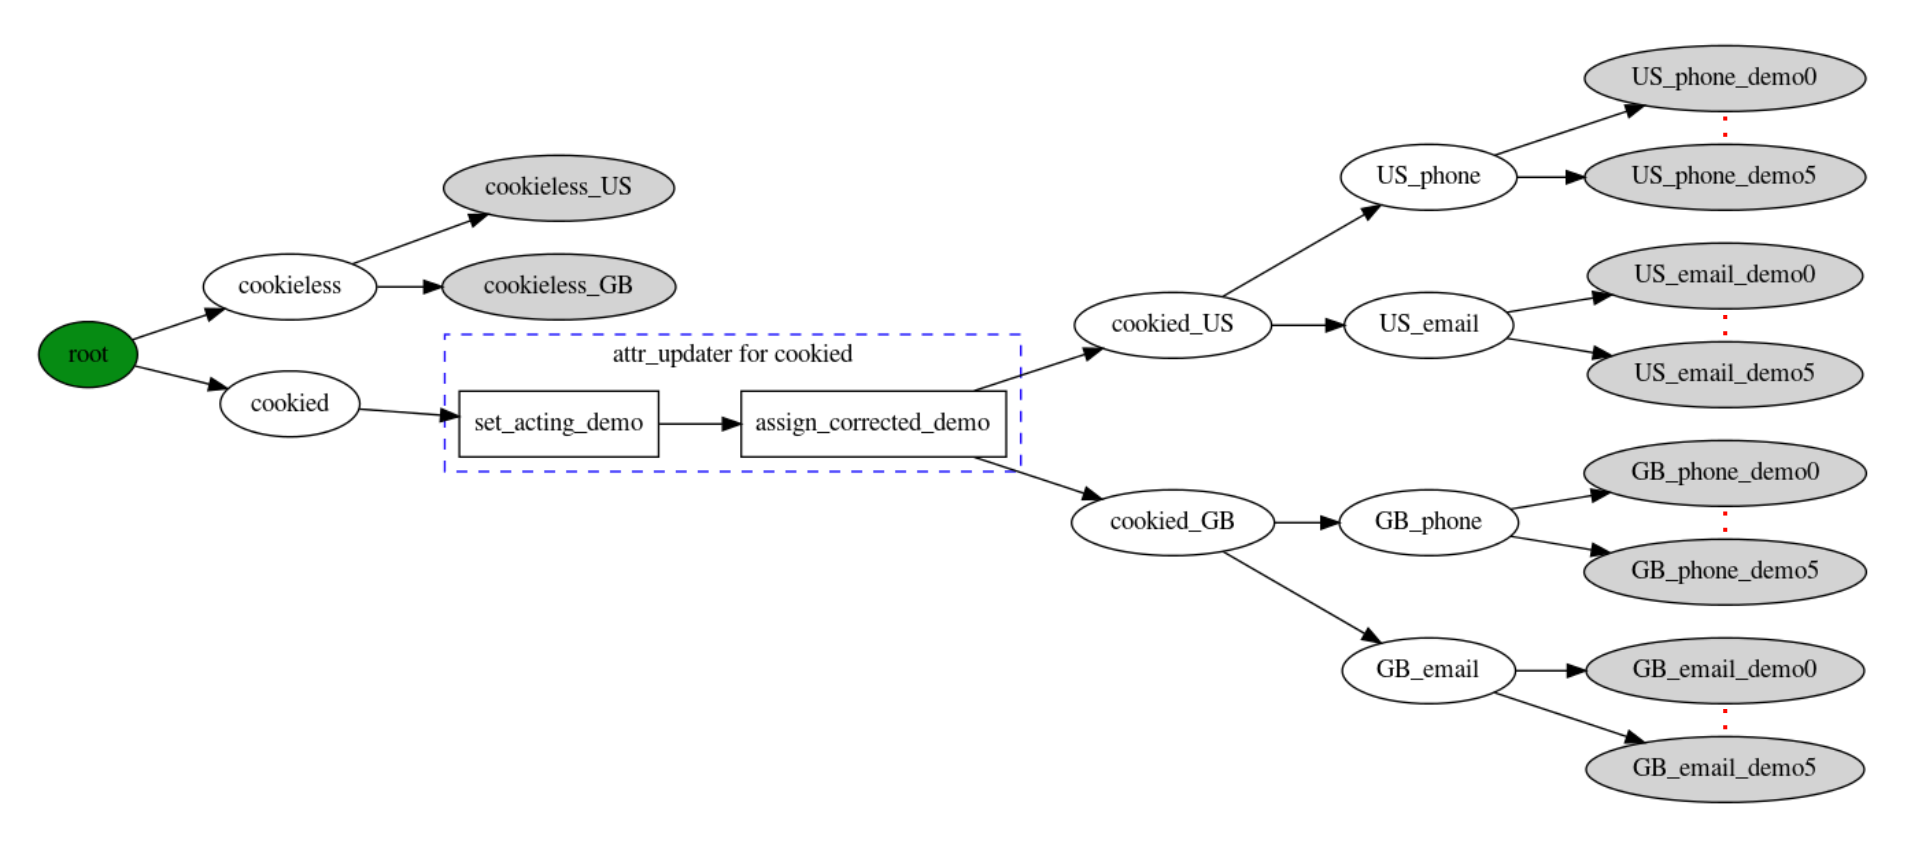 


In [8]:
def get_set_acting_demo_updater() -> AttrUpdaterChain:
  """Builds an updater for setting acting demo.

  If the phone demo exists, use phone demo.
  Else use email demo.

  Returns:
    An AttrUpdaterChain for setting acting demo.
  """
  chain = AttrUpdaterChain(name='set_acting_demo', seed='set_acting_demo')

  # The nodes are checked in order.

  # If has phone user info, use phone demo.
  for demo in DEMO:
    branch = chain.add_node()
    branch.condition.add_attr('phone_user_info.demo.gender', demo.gender)
    branch.condition.add_attr('phone_user_info.demo.age_from', demo.age_from)
    branch.condition.add_attr('phone_user_info.demo.age_to', demo.age_to)
    branch.update.add_attr('acting_user_space', PHONE)
    branch.update.add_attr('acting_demo.gender', demo.gender)
    branch.update.add_attr('acting_demo.age_from', demo.age_from)
    branch.update.add_attr('acting_demo.age_to', demo.age_to)

  # Else if has email demo, use email demo.
  for demo in DEMO:
    branch = chain.add_node()
    branch.condition.add_attr('email_user_info.demo.gender', demo.gender)
    branch.condition.add_attr('email_user_info.demo.age_from', demo.age_from)
    branch.condition.add_attr('email_user_info.demo.age_to', demo.age_to)
    branch.update.add_attr('acting_user_space', EMAIL)
    branch.update.add_attr('acting_demo.gender', demo.gender)
    branch.update.add_attr('acting_demo.age_from', demo.age_from)
    branch.update.add_attr('acting_demo.age_to', demo.age_to)

  # Else do nothing.

  return chain


def get_demo_redistribution_updater(
    redistribution: Dict[str, List[List[float]]]) -> AttrUpdaterMatrix:
  """Builds an updater for demo redistribution.

  Set corrected demo using the redistribution matrix.

  Args:
    redistribution: dictionary, key = country, value = redistribution matrix for
      the country.  In the matrix, column = acting demo (from phone demo or
      cookie demo, chosen by the model), row = corrected demo (this is also the
      demo of the virtual person).  Both column and row use the demo buckets in
      DEMO.

  Returns:
    An AttrUpdaterMatrix for setting corrected demo.
  """
  matrix = AttrUpdaterMatrix(name='redistribution', seed='redistribution')

  # Add columns for country/demo combinations.
  for country in sorted(redistribution):
    for demo in DEMO:
      attrs = matrix.add_column()
      attrs.add_attr('country', country)
      attrs.add_attr('acting_demo.gender', demo.gender)
      attrs.add_attr('acting_demo.age_from', demo.age_from)
      attrs.add_attr('acting_demo.age_to', demo.age_to)

  # Add rows for demo buckets.
  for demo in DEMO:
    attrs = matrix.add_row()
    attrs.add_attr('corrected_demo.gender', demo.gender)
    attrs.add_attr('corrected_demo.age_from', demo.age_from)
    attrs.add_attr('corrected_demo.age_to', demo.age_to)

  # Add redistribution matrix.
  matrices = [redistribution[country] for country in sorted(redistribution)]
  r = numpy.concatenate(matrices, axis=1)
  matrix.set_probability(numpy.reshape(r, (-1)))

  return matrix


def get_cookied_pool(census: Dict[str, List[Tuple[int, int]]]) -> ModelNode:
  """Builds a model node for cookied events (with phone data or email data).

  This is a tree.
  1st level: country node
  2nd level: id space node
  3rd level: population pool for each demo bucket

  Args:
    census: dictionary, key = country, value = list of (offset, population), the
      i-th item is for i-th demo bucket.

  Returns:
    The root node of the tree.
  """
  prefix = 'cookied_pool'
  root = ModelNode(name=prefix)
  for country in sorted(census):
    country_node = ModelNode(name=prefix + '-' + country)
    country_node.condition.add_attr('country', country)
    root.children.append(country_node)
    for user_space in [PHONE, EMAIL]:
      cookie_type_node = ModelNode(name=prefix + '-' + country + '-' +
                                   user_space)
      cookie_type_node.condition.add_attr('acting_user_space', user_space)
      country_node.children.append(cookie_type_node)
      for demo_index in range(N_DEMO_BUCKETS):
        demo = DEMO[demo_index]
        seed = prefix + '-' + country + '-' + user_space + '-' + str(demo)
        demo_pool = PopulationNode(name=seed, seed=seed)
        demo_pool.condition.add_attr('corrected_demo.gender', demo.gender)
        demo_pool.condition.add_attr('corrected_demo.age_from', demo.age_from)
        demo_pool.condition.add_attr('corrected_demo.age_to', demo.age_to)
        cookie_type_node.children.append(demo_pool)

        # Assume each user id space can reach all virtual people in this demo
        # bucket.
        census_records = [census[country][demo_index]]
        # Sets up the pool in the current object, which is a list of Tribes.
        demo_pool.build_pool(census_records, COOKIED_DIRAC_MIXTURE.alphas,
                             _get_activities_for_id_space(user_space))

  return root


def get_cookieless_pool(census: Dict[str, List[Tuple[int, int]]]) -> ModelNode:
  """Builds a model node for cookieless events.

  This is a tree.
  Cookieless events only have geo data.
  1st level: population pool for each country

  Args:
    census: dictionary, key = country, value = list of (offset, population), the
      i-th item is for i-th demo bucket.

  Returns:
    The root node of the tree.
  """
  prefix = 'cookieless_pool'
  root = ModelNode(name=prefix)
  for country in sorted(census):
    seed = prefix + '-' + country
    country_node = PopulationNode(name=seed, seed=seed)
    country_node.condition.add_attr('country', country)
    root.children.append(country_node)

    census_records = []
    for demo_index in range(N_DEMO_BUCKETS):
      offset, population = census[country][demo_index]
      census_records.append((offset, int(population * COOKIELESS_PERCENTAGE)))
    country_node.build_pool(census_records, COOKIELESS_DIRAC_MIXTURE.alphas,
                            _get_activities_for_id_space(COOKIELESS))

  return root


def printRoute(stack, root):
    if root == None:
        return

    # append this node to the path array
    stack.append(str(root))
    if(len(root.children) == 0):
          
        # print out all of its 
        # root - to - leaf
        print('-------->'.join([str(i) for i in stack]))
        print("MAHI_NEXT")
          
    # otherwise try both subtrees
    for i in root.children:
      printRoute(stack, i)
    stack.pop()


def build_model(census: Dict[str, List[Tuple[int, int]]],
                redistribution: Dict[str, List[List[float]]]) -> ModelNode:
  """Builds a toy model.

  It is a tree:
  root: children ['cookied', 'cookieless'],
  cookieless: children ['cookieless_pool']
  cookied: updater ['set_acting_demo', 'assign_corrected_demo'],
      children ['cookied_pool']

  Args:
    census: dictionary, key = country, value = list of (offset, population), the
      i-th item is for i-th demo bucket.
    redistribution: dictionary, key = country, value = redistribution matrix for
      the country.  In the matrix, column = acting demo (from phone demo or
      cookie demo, chosen by the model), row = corrected demo (this is also the
      demo of the virtual person).  Both column and row use the demo buckets in
      DEMO.

  Returns:
    The root node of the built model.
  """
  # --- Generate nodes
  root_node = ModelNode('root')

  # For simplicity, assume that profile data is either None or full data
  cookieless = ModelNode('cookieless')
  cookieless.condition.add_attr('phone_user_info', None)
  cookieless.condition.add_attr('email_user_info', None)

  # Use empty condition for cookied, which always match.

  # The children models are matched in order, first check cookieless,
  # and the rest will always go to cookied.
  cookied = ModelNode('cookied')

  set_acting_demo = get_set_acting_demo_updater()
  assign_corrected_demo = get_demo_redistribution_updater(redistribution)
  cookied_pool = get_cookied_pool(census)
  cookieless_pool = get_cookieless_pool(census)

  # --- Connecting nodes
  root_node.children = [cookieless, cookied]
  cookieless.children = [cookieless_pool]

  # Updaters are applied in order.
  cookied.attr_updater = [set_acting_demo, assign_corrected_demo]
  cookied.children = [cookied_pool]

  # printRoute([], root_node)

  # Q=Queue()
  # Q.put(root_node)
  # while(not Q.empty()):
  #   size = Q.qsize()
  #   index = 0
  #   print("New Level")
  #   while index < size:
  #     index += 1
  #     node = Q.get()
  #     if node == None:
  #       print("No Child")
  #     else:
  #       print(str(node))
  #     for child_node in node.children:
  #       Q.put(child_node)
  # return root_node


model = build_model(CENSUS, REDISTRIBUTION)

Model Node - name = "root", seed = "root, condition = "AttrNameValueList - []", updater = "[]"
Model Node - name = "root", seed = "root, condition = "AttrNameValueList - []", updater = "[]"-------->Model Node - name = "cookieless", seed = "cookieless, condition = "AttrNameValueList - [AttrNameValue - attr = "phone_user_info", value = None,
AttrNameValue - attr = "email_user_info", value = None]", updater = "[]"-------->Model Node - name = "cookieless_pool", seed = "cookieless_pool, condition = "AttrNameValueList - []", updater = "[]"-------->Population Node - Name: cookieless_pool-GB, Seed: cookieless_pool-GB, Pool: ['Tribe - [offset = 11000000000, population = 1524\noffset = 12000000000, population = 1524\noffset = 13000000000, population = 2032\noffset = 14000000000, population = 2032\noffset = 15000000000, population = 1016\noffset = 16000000000, population = 1016]', 'Tribe - [offset = 11000001524, population = 4072\noffset = 12000001524, population = 4072\noffset = 13000002032, pop

# Example: label events

* The toy model returns 0 or 1 virtual person for a given event.
* A real model may also returns > 1 virtual people (coview). 


In [ ]:
from google.colab import widgets


def label_events(country: str):
  """Demonstrates labeling events."""
  model = build_model(CENSUS, REDISTRIBUTION)
  for i in range(1, 21):
    event = Event(str(i))
    event.country = country
    event.phone_user_info = UserInfo(
        user_id=PHONE + str(i + 10000), demo=DEMO[1])
    print("Before----------------------------------------------")
    print(event)
    print('event_id: {}, labeling output: [{}]'.format(
        event.event_id.rjust(2, ' '),
        '\n'.join(str(x) for x in model.apply_model(event))))
    print("After----------------------------------------------")
    print(event)


subtab = widgets.TabBar(sorted(CENSUS))

for country in sorted(CENSUS):
  with subtab.output_to(country):
    label_events(country)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Before----------------------------------------------
Event: [event_id: 1,
country: GB,
phone_user_info: user id = phone10001, demo = F25-34,
email_user_info: None,
acting_user_space: None,
acting_demo: UNone-None,
corrected_demo: UNone-None]
**************** Before Setting AttrNameValue update_event*******************
Event: [event_id: 1,
country: GB,
phone_user_info: user id = phone10001, demo = F25-34,
email_user_info: None,
acting_user_space: None,
acting_demo: UNone-None,
corrected_demo: UNone-None]
**************** After setting AttrNameValue update_event*******************
Event: [event_id: 1,
country: GB,
phone_user_info: user id = phone10001, demo = F25-34,
email_user_info: None,
acting_user_space: phone,
acting_demo: UNone-None,
corrected_demo: UNone-None]
***attribute was:***
acting_user_space
***value was:***
phone
**************** Before Setting AttrNameValue update_event*******************
UNone-None
**************** After setting AttrNameValue update_event****************

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Before----------------------------------------------
Event: [event_id: 1,
country: US,
phone_user_info: user id = phone10001, demo = F25-34,
email_user_info: None,
acting_user_space: None,
acting_demo: UNone-None,
corrected_demo: UNone-None]
**************** Before Setting AttrNameValue update_event*******************
Event: [event_id: 1,
country: US,
phone_user_info: user id = phone10001, demo = F25-34,
email_user_info: None,
acting_user_space: None,
acting_demo: UNone-None,
corrected_demo: UNone-None]
**************** After setting AttrNameValue update_event*******************
Event: [event_id: 1,
country: US,
phone_user_info: user id = phone10001, demo = F25-34,
email_user_info: None,
acting_user_space: phone,
acting_demo: UNone-None,
corrected_demo: UNone-None]
***attribute was:***
acting_user_space
***value was:***
phone
**************** Before Setting AttrNameValue update_event*******************
UNone-None
**************** After setting AttrNameValue update_event****************

<IPython.core.display.Javascript object>

# Example: compute reach for cookieless events

* reach = count of unique virtual person id
* compare against the expected reach

In [ ]:
from google.colab import widgets
import matplotlib.pyplot as plt


def reach_for_cookieless(country):
  """Demonstrates reach for cookieless events."""
  model = build_model(CENSUS, REDISTRIBUTION)
  kappa = KAPPA[COOKIELESS]
  total_population = sum(x for _, x in CENSUS[country]) * COOKIELESS_PERCENTAGE
  bow_type = BOW_TYPE[COOKIELESS]
  reach_func = get_reach_func(bow_type)
  print('{} with kappa = {}'.format(bow_type, kappa))

  plot_data = [[0], [0], [0]]
  reach = set()
  zero_vp_count = 0
  for i in range(1, 100001):
    event = Event(str(i))
    event.country = country

    vp = model.apply_model(event)
    if vp:
      reach.add(vp[0].virtual_person_id)
    else:
      zero_vp_count += 1

    if i % 100 == 0:
      plot_data[0].append(i)
      plot_data[1].append(len(reach))
      plot_data[2].append(
          log_bow_reach(population=total_population, kappa=kappa, x=i))

    if i % 10000 == 0:
      print(
          'event = {:6d}, reach = {:5d}, zero vp count = {:5d}, '
          ' expected reach = {:5.0f}'
          .format(i, len(reach), zero_vp_count,
                  reach_func(population=total_population, kappa=kappa, x=i)))
      

  plt.figure(figsize=(15,10))
  plt.plot(plot_data[0], plot_data[1], 'b', label='actual reach', linewidth=2)
  plt.plot(plot_data[0], plot_data[2], 'r', label='expected reach', linewidth=2)
  plt.legend()
  plt.show()


subtab = widgets.TabBar(sorted(CENSUS))

for country in sorted(CENSUS):
  with subtab.output_to(country):
    reach_for_cookieless(country)

# Example: compute reach and demo distribution for events with user id
* Use demo redistribution matrix to assign corrected demo
* reach by demo bucket = count of unique virtual person id with the corresponding virtual person demo (= corrected demo if not consider coview)
* demo distribution by reach = normalized reach by demo buckets
* total reach = reach over all demo buckets
* expected reach: 
** compute expected number of events by corrected demo
** compute expected reach for each demo bucket
** sum over all demo buckets



In [ ]:
from google.colab import widgets
import itertools
import matplotlib.pyplot as plt


def _compute_distribution_string(raw_data: List[float]):
  """Normalizes input and returns it as a string.

  Args:
    raw_data: the input data to normalize.

  Returns:
    The distributionn as a string.
  """
  total = sum(raw_data)
  return '[{}]'.format(', '.join(
      '{:5.2f}%'.format(x * 100) for x in numpy.array(raw_data) / total))


def reach_for_cookied(country, id_space, input_demo_bucket):
  """Demonstrates reach for cookied events."""
  model = build_model(CENSUS, REDISTRIBUTION)

  bow_type = BOW_TYPE[id_space]
  reach_func = get_reach_func(bow_type)
  kappa = KAPPA[id_space]
  print('{} with kappa = {}'.format(bow_type, kappa))
  
  demo_population = [x for _, x in CENSUS[country]]
  corrected_demo_prob = numpy.array(
      [REDISTRIBUTION[US][i][input_demo_bucket] for i in range(N_DEMO_BUCKETS)])
  print('expected corrected demo distribution by impression:',
        _compute_distribution_string(corrected_demo_prob))
    
  plot_data = [[0], [0], [0]]
  demo_impressions = numpy.zeros(N_DEMO_BUCKETS)
  demo_reach = [set() for i in range(N_DEMO_BUCKETS)]
  zero_vp_count = 0
  for i in range(1, 100001):
    event = Event(str(i))
    event.country = country
    user_info = UserInfo(
        user_id=str(i + 1000000), demo=DEMO[input_demo_bucket])
    if id_space == EMAIL:
      event.email_user_info = user_info
    else:
      event.phone_user_info = user_info

    vp = model.apply_model(event)
    if vp:
      for person in vp:
        out_demo_index = get_demo_index(person.demo)
        demo_impressions[out_demo_index] += 1
        demo_reach[out_demo_index].add(person.virtual_person_id)
    else:
      zero_vp_count += 1

    # Compute actual and expected reach so far.
    if i % 100 == 0:
      expected_corrected_demo = corrected_demo_prob * i
      expected_reachs = []
      for demo_index in range(N_DEMO_BUCKETS):
        expected_reachs.append(
            reach_func(
                population=demo_population[demo_index],
                kappa=kappa,
                x=expected_corrected_demo[demo_index]))
        
      total_reach = sum(len(x) for x in demo_reach)

      plot_data[0].append(i)
      plot_data[1].append(total_reach)
      plot_data[2].append(sum(expected_reachs))

      if i % 10000 == 0:
        print(
            'event = {}, reach = {}, zero vp count = {},'
            ' expected reach = {:.0f}'
            .format(i, total_reach, zero_vp_count, sum(expected_reachs)))
        print('demo distribution by impression:',
              _compute_distribution_string(demo_impressions))
        print('demo distribution by reach:     ',
              _compute_distribution_string([len(x) for x in demo_reach]))
        print('expected demo distrib by reach: ',
              _compute_distribution_string(expected_reachs))

  plt.figure(figsize=(15,10))
  plt.plot(plot_data[0], plot_data[1], 'b', label='actual reach', linewidth=2)
  plt.plot(plot_data[0], plot_data[2], 'r', label='expected reach', linewidth=2)
  plt.legend()
  plt.show()


# Use input demo bucket 1.

id_spaces = [PHONE, EMAIL]
subtab = widgets.TabBar(['{}/{}'.format(x, y) for x, y in itertools.product(sorted(CENSUS), id_spaces)])

for country, space in itertools.product(sorted(CENSUS), id_spaces):
  with subtab.output_to('{}/{}'.format(country, space)):
    reach_for_cookied(country, space, input_demo_bucket=1)

In [ ]:
# Use input demo bucket 5.

id_spaces = [PHONE, EMAIL]
subtab = widgets.TabBar(['{}/{}'.format(x, y) for x, y in itertools.product(sorted(CENSUS), id_spaces)])

for country, space in itertools.product(sorted(CENSUS), id_spaces):
  with subtab.output_to('{}/{}'.format(country, space)):
    reach_for_cookied(country, space, input_demo_bucket=5)